In [1]:
#Bibliotecas
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import os
import pandas as pd
from skimage.feature import hog

In [2]:
#Machine Learning 
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [3]:
#Deep
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models

config =  tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess =  tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)
%matplotlib inline

In [4]:
deep1 = pd.read_csv('../deep_learning/features_mobilenet.csv',index_col=False)
deep2 = pd.read_csv('../deep_learning/features_inceptionResNetV2.csv',index_col=False)
deep3 = pd.read_csv('../deep_learning/features_vgg16.csv',index_col=False)


In [5]:
deep1_1 = deep1.iloc[:,1:]
deep2_1 = deep2.iloc[:,1:]
deep3_1 = deep3.iloc[:,1:]

In [6]:
def roc(X_train, y_train, X_test, y_test, mean_fpr, aucs, tprs, cls, l):
    i = 0
    for c in cls:
        probas_ = c.fit(X_train, y_train).predict_proba(X_test)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(label_binarize(y_test, classes=[0, 1]), probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC %s (AUC = %0.5f)' % (l[i], roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    return(plt)

In [7]:
fold = [[],[],[],[],[]]
k = 0
for i in range(0,2000,5):
    for j in range(5):
        fold[k%5].append(j+i)
    k+=1
tt1 = fold[0]+fold[1]+fold[2]+fold[3],fold[4]
tt2 = fold[1]+fold[2]+fold[3]+fold[4],fold[0]
tt3 = fold[0]+fold[2]+fold[3]+fold[4],fold[1]
tt4 = fold[0]+fold[1]+fold[3]+fold[4],fold[2]
tt5 = fold[0]+fold[1]+fold[2]+fold[4],fold[3]

In [8]:
treino1_name = (deep1_1.iloc[tt1[0]])['nome']
teste1_name =  (deep1_1.iloc[tt1[1]])['nome']

In [9]:
teste_img_name = set()
for i in teste1_name:
    aux = i.split('_')
    teste_img_name.add(aux[0])

In [10]:
with tf.keras.utils.CustomObjectScope({'relu6':  tf.nn.relu6,
                        }):
    #modelo1 = models.load_model('../deep_model/estomato_InceptionResNetV2_final.h5')
    #modelo = models.load_model('../deep_model/estomato_mobileNet.h5')
    modelo3 = models.load_model('../deep_learning/estomato_vgg16.h5')

In [11]:
#modelo3.pop()
modelo3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              25691136  
Total params: 40,405,824
Trainable params: 32,770,560
Non-trainable params: 7,635,264
_________________________________________________________________


In [12]:
classifiers = [
    SVC(kernel="linear", C=0.025, probability=True),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
]
    
cls = ["SVM linear",
       "MLP",
       "AdaBoost",
]

In [17]:
trained_models_cls = []
for i in classifiers:
    for j in [deep3_1]:
        treino_X = j.iloc[:,:-1]
        treino_Y = j['class']
        trained_models_cls.append(i.fit(treino_X.iloc[tt1[0]], treino_Y.iloc[tt1[0]]))

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [20]:
dir_test = '../../data/original2/'
test_image = ['139']
matrices = {}
import time
inicio = time.time()
cnt1 = 0
image = {}
for name in test_image:#,'147']:#teste_img_name:
    # Reading image
    image[name]=cv2.imread(dir_test+name+'.jpg')
    #Create an auxiliary matrix
    aux_image = np.zeros((image[name].shape[0],image[name].shape[1]))
    
    #Iterate over image
    for i in range(0,image[name].shape[0],100):
        for j in range(0,image[name].shape[1],100):
            #Creating window
            i1 = i+100#151
            j1 = j+100#258
            #Out of dimension
            if(i1 >= image[name].shape[0] or j1 >= image[name].shape[1]):
                break
            #Okay
            window = image[name][i:i+100,j:j+100]
            window = cv2.resize(window,(224,224))
            window_r = window.reshape(1,224,224,3)
            features = modelo3.predict(window_r)
            class_window = trained_models_cls[0].predict(features)
            if(class_window):
                for x1 in range(i,i1):
                    for y1 in range(j,j1):
                        aux_image[x1][y1] +=1 #255
                cv2.imwrite(str(cnt1)+'.jpg', window)
                cnt1+=1
            #Out of dimension
            if(i1 >= image[name].shape[0]):
                break
    
    #Take output matrix
    matrices[name] = aux_image
    
print(time.time()-inicio)

281.6478703022003


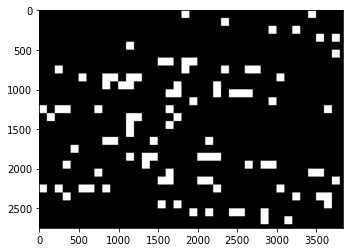

In [21]:
plt.imshow(matrices['139'],cmap='gray')

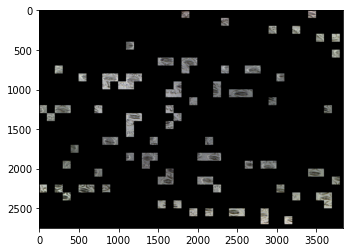

In [22]:
for name in ['139']:#,'147']:
    and_img = np.zeros(image[name].shape,dtype=np.uint16)
    for i in range(matrices[name].shape[0]):
        for j in range(matrices[name].shape[1]):
            if matrices[name][i][j]:
                for k in range(3):
                    and_img[i][j][k] = image[name][i][j][k]
    plt.imshow(and_img, cmap='brg')       
    cv2.imwrite(name+'_ale.jpg',and_img)